[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/edwinRNDR/workshop-meme-viz/blob/master/notebooks/feature-to-year-regression.ipynb)

# Setup environment

In [2]:
!pip install pandas scikit-learn tqdm

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/



# Get meme data

In [3]:
!gdown 1qEGE-ap4pl9DNlD9FQGvrQjJORgksFxG

Downloading...
From: https://drive.google.com/uc?id=1qEGE-ap4pl9DNlD9FQGvrQjJORgksFxG
To: /content/memes-all.json
100% 23.1M/23.1M [00:00<00:00, 53.8MB/s]


# Supply feature data (logits/softmax)

You have to upload a logits or softmax csv to the colab environment. Set the `feature_path` variable to the filename of the file that you have uploaded.



In [7]:
features_path = "prompt-logits.csv"

# Preprocess data and inititalize neural network

In [26]:
import pandas as pd
import torch
from tqdm import tqdm
from torch import nn
import json
import numpy as np

from sklearn.preprocessing import StandardScaler
from torch.utils.data import SubsetRandomSampler

class Dataset(torch.utils.data.Dataset):
    def __init__(self, X, y, scale_data=True):
        if not torch.is_tensor(X) and not torch.is_tensor(y):
            # Apply scaling if necessary
            if scale_data:
                X = StandardScaler().fit_transform(X)
            self.X = torch.from_numpy(X)
            self.y = torch.from_numpy(y)

    def __len__(self):
        return len(self.X)

    def __getitem__(self, i):
        return self.X[i], self.y[i]

class MLP(nn.Module):
    def __init__(self, inputs):
        super().__init__()
        self.layers = nn.Sequential(
            nn.Linear(inputs, 128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, 1)
        )

    def forward(self, x):
        return self.layers(x)

features_df = pd.read_csv(features_path)

meme_dataset_path = "memes-all.json"
memes = json.load(open(meme_dataset_path, encoding="utf-8"))

years = [meme.get("year", np.nan) for meme in memes]
years_df = pd.DataFrame(years)
years_df = years_df.rename({0: "year"},axis=1)

assert years_df.shape[0] == features_df.shape[0], "number of rows in json and csv should match"

full_df = pd.concat([features_df, years_df], axis=1)
filtered_df = full_df.dropna(axis='rows')

dataset_all = Dataset(features_df, np.asarray(years))

filtered_years_df = filtered_df.filter(['year'], axis=1)
filtered_features_df = filtered_df.drop(['year'], axis=1)

dataset_filtered = Dataset(filtered_features_df, filtered_years_df.iloc[:,0:].values)

train_size = filtered_df.shape[0] // 2
valid_size = filtered_df.shape[0] - train_size

train_set, val_set = torch.utils.data.random_split(dataset_filtered, [train_size, valid_size])

train_sampler = SubsetRandomSampler(train_set.indices)
valid_sampler = SubsetRandomSampler(val_set.indices)

train_loader = torch.utils.data.DataLoader(dataset_filtered, batch_size=10, num_workers=1, sampler=train_sampler)
valid_loader = torch.utils.data.DataLoader(dataset_filtered, batch_size=10, num_workers=1, sampler=valid_sampler)
torch.manual_seed(42)

# Initialize the MLP
mlp = MLP(features_df.shape[1])

# Define the loss function and optimizer
loss_function = nn.L1Loss()
optimizer = torch.optim.Adam(mlp.parameters(), lr=1e-4)


# Train neural network




In [27]:
min_valid_loss = 1e20
max_training_epochs = 150

# Run the training loop
pbar = tqdm(range(0, max_training_epochs))
for epoch in pbar:
    # Set current loss value
    train_loss = 0.0

    mlp.train()
    # Iterate over the DataLoader for training data
    for i, data in enumerate(train_loader, 0):

        # Get and prepare inputs
        inputs, targets = data
        inputs, targets = inputs.float(), targets.float()
        targets = targets.reshape((targets.shape[0], 1))

        # Zero the gradients
        optimizer.zero_grad()

        # Perform forward pass
        outputs = mlp(inputs)

        # Compute loss
        loss = loss_function(outputs, targets)

        # Perform backward pass
        loss.backward()

        # Perform optimization
        optimizer.step()

        # Print statistics
        train_loss += loss.item()

    mlp.eval()
    valid_loss = 0.0
    for i, data in enumerate(valid_loader, 0):
        inputs, targets = data
        inputs, targets = inputs.float(), targets.float()
        outputs = mlp(inputs)
        loss = loss_function(outputs, targets)
        valid_loss += loss.item()

    if valid_loss < min_valid_loss:
        min_valid_loss = valid_loss

    if valid_loss > min_valid_loss * 1.05:
        print("validation loss increased, halting")
        break

    pbar.set_postfix({ "train loss": f"{train_loss:.1f}", "validation loss": f"{valid_loss:.1f}"})

 74%|███████▍  | 111/150 [03:42<01:18,  2.00s/it, train loss=2220.8, validation loss=2281.3]

validation loss increased, halting


# Write results to csv

In [28]:
a = mlp.forward(dataset_all.X.to(torch.float32))

out_df = pd.DataFrame(a.detach().numpy())
out_df = out_df.rename(columns={ 0 : 'predicted year'})
out_df.to_csv("regression.csv")

compare_df = pd.concat([years_df, out_df], axis=1)
compare_df.to_csv("regression-compare.csv")

# Visualize results

A perfect predictor would show a diagonal line. 



(1990.0, 2050.0)

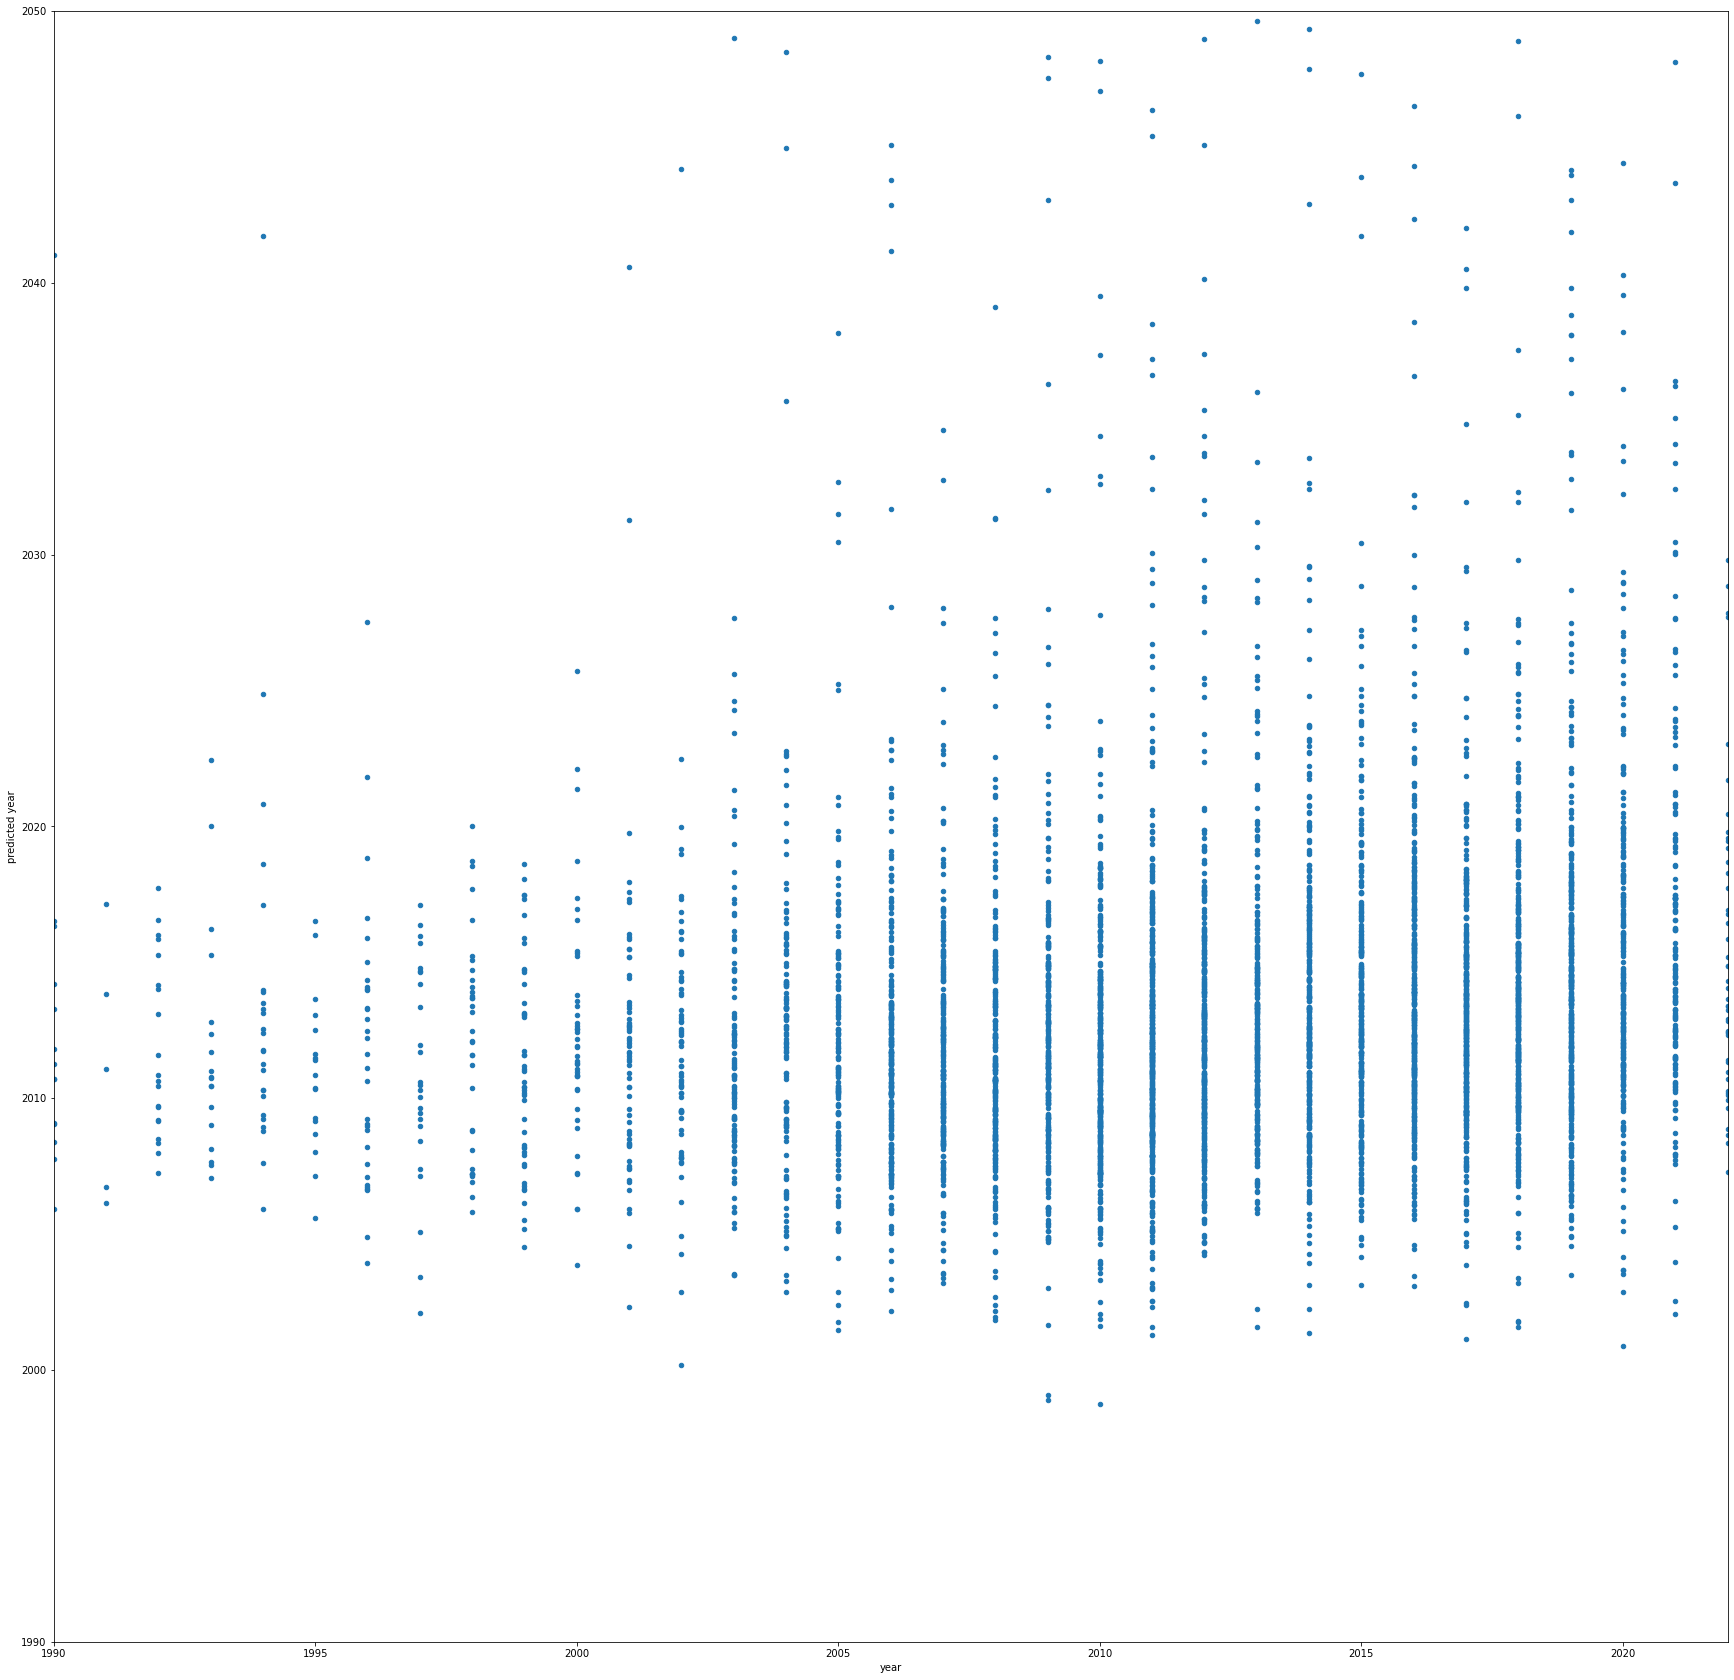

In [41]:
filtered_compare_df = compare_df.dropna(axis=0)

ax = filtered_compare_df.plot.scatter(x='year', y='predicted year')
ax.get_figure().set_figwidth(30)
ax.get_figure().set_figheight(30)
ax.set_xlim([1990, 2022])
ax.set_ylim([1990, 2050])